<a href="https://colab.research.google.com/github/JohnThefive/Ray_Tracing_Simulacao_sistema_solar/blob/main/Implementa%C3%A7%C3%A3o_Canny_Detector_Jo%C3%A3o_Gabriel_e_Dionys_Eicholz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

(<Axes: title={'center': 'Tons de Cinza'}>,
 Text(0.5, 1.0, 'Tons de Cinza'))

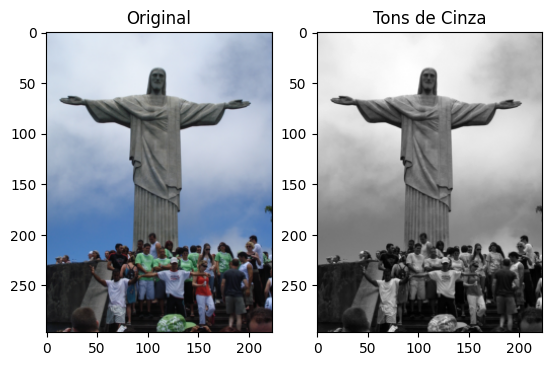

In [6]:
#Carregando a imagem
path_image = "/content/sample_data/cristo_redentor.png"
img = cv.imread(path_image, cv.IMREAD_COLOR)
assert img is not None, "file could not be read, check with os.path.exists()"

#convertendo de BGR para RGB para compatibilizar com o matplotlib
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(img),plt.title('Original')


#RGB para grayscale
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plt.subplot(122),plt.imshow(img_gray, cmap = 'gray'),plt.title('Tons de Cinza')

(<Axes: title={'center': 'Suavizada (Sigma=2)'}>,
 Text(0.5, 1.0, 'Suavizada (Sigma=2)'),
 ([], []),
 ([], []))

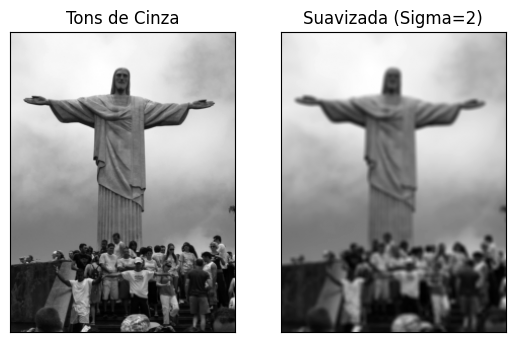

In [7]:
#Step 1 - Gaussian filtering - https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
plt.subplot(121),plt.imshow(img_gray, cmap = 'gray'),plt.title('Tons de Cinza'),plt.xticks([]), plt.yticks([])
img_blur = cv.GaussianBlur(img_gray, (5,5), 2)
plt.subplot(122),plt.imshow(img_blur, cmap = 'gray'),plt.title('Suavizada (Sigma=2)'),plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'Sobel Gradient y'), ([], []), ([], []))

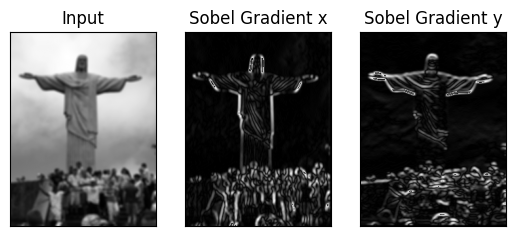

In [8]:
# Step 2 - Apply a basic gradient estimator (e.g.: Sobel or Prewitt)
#https://docs.opencv.org/3.4/d5/d0f/tutorial_py_gradients.html
#https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html

#prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
#prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
#grad_x = cv.filter2D(img,-1,prewitt_x)
#grad_y = cv.filter2D(img,-1,prewitt_y)


# Output dtype = cv.CV_64F
grad_x = cv.Sobel(img_blur,cv.CV_64F,1,0,ksize=3)
grad_y = cv.Sobel(img_blur,cv.CV_64F,0,1,ksize=3)

# Then take its absolute and convert to cv.CV_8U to show as an grayscale image
abs_grad_x = np.absolute(grad_x)
grad_x_8u = np.uint8(abs_grad_x)
abs_grad_y = np.absolute(grad_y)
grad_y_8u = np.uint8(abs_grad_y)

plt.subplot(1,3,1),plt.imshow(img_blur,cmap = 'gray')
plt.title('Input'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(grad_x_8u,cmap = 'gray')
plt.title('Sobel Gradient x'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(grad_y_8u,cmap = 'gray')
plt.title('Sobel Gradient y'), plt.xticks([]), plt.yticks([])

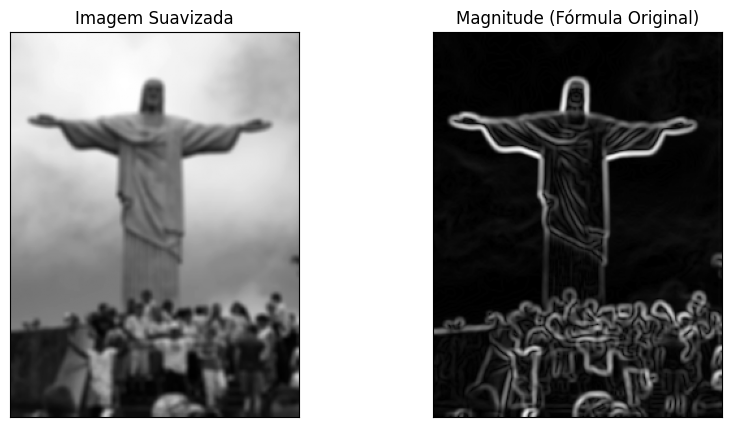

Dimensões da matriz de magnitude: (297, 223)
Dimensões da matriz de direção (em graus): (297, 223)


In [9]:
# Step 2.1 - Magnitude and Direction

#Magnitude - sqrt(gx^2 + gy^2)
magnitude = np.sqrt(grad_x**2 + grad_y**2)

#direção - arctan2(Gy, Gx)
direcao = np.arctan2(grad_y, grad_x)

#Convertendo pra Graus
angulo_da_direcao = np.rad2deg(direcao)

# Normalizando a magnitude para o intervalo 0-255
magnitude_8u = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

# Plotando a magnitude do gradiente
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_blur, cmap='gray'), plt.title('Imagem Suavizada')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_8u, cmap='gray'), plt.title('Magnitude (Fórmula Original)')
plt.xticks([]), plt.yticks([])
plt.show()

# "força" da borda de cada pixel
print("Dimensões da matriz de magnitude:", magnitude.shape)
#Angulo da direção de cada pixel
print("Dimensões da matriz de direção (em graus):", angulo_da_direcao.shape)



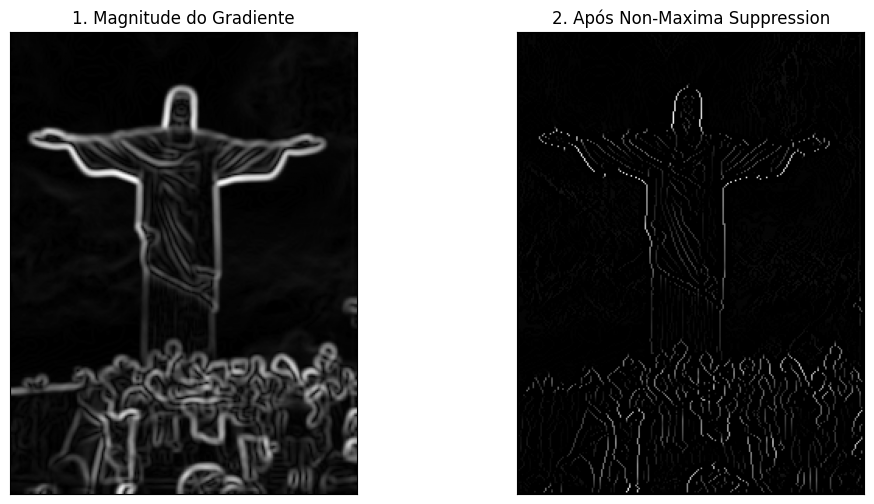

In [12]:
# Step 3 - Non-maxima suppression - supressão de não maximos

def non_max_suppression(magnitude, dir):

   linhas, colunas = magnitude.shape
   nms_resultado = np.zeros((linhas, colunas), dtype=np.float32)

   # Normalizando os ângulos para o intervalo [0, 180)
   angulo = direcao % 180

   # Iterar sobre todos os pixels da imagem
   for i in range(1, linhas-1):
       for j in range(1, colunas-1):
           try:
               # Vizinhos na direção do gradiente
               q = 255
               r = 255
              # Ângulo 0
               if (0 <= angulo[i,j] < 22.5) or (157.5 <= angulo[i,j] <= 180):
                   q = magnitude[i, j+1]
                   r = magnitude[i, j-1]
               # Ângulo 45
               elif (22.5 <= angulo[i,j] < 67.5):
                   q = magnitude[i+1, j-1]
                   r = magnitude[i-1, j+1]
               # Ângulo 90
               elif (67.5 <= angulo[i,j] < 112.5):
                   q = magnitude[i+1, j]
                   r = magnitude[i-1, j]
               # Ângulo 135
               elif (112.5 <= angulo[i,j] < 157.5):
                   q = magnitude[i-1, j-1]
                   r = magnitude[i+1, j+1]
               # Se o pixel atual for um maximo local, mantem seu valor
               if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                   nms_resultado[i,j] = magnitude[i,j]
               else:
                   nms_resultado[i,j] = 0
           except IndexError as e:
               pass
   return nms_resultado

#aplicando NMS
nms_image = non_max_suppression(magnitude, angulo_da_direcao)

#normalizando a imagem
nms_image_8u = cv.normalize(nms_image, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

# Plotando os resultados para comparação
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(magnitude_8u, cmap='gray')
plt.title('1. Magnitude do Gradiente')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(nms_image_8u, cmap='gray')
plt.title('2. Após Non-Maxima Suppression')
plt.xticks([]), plt.yticks([])

plt.show()




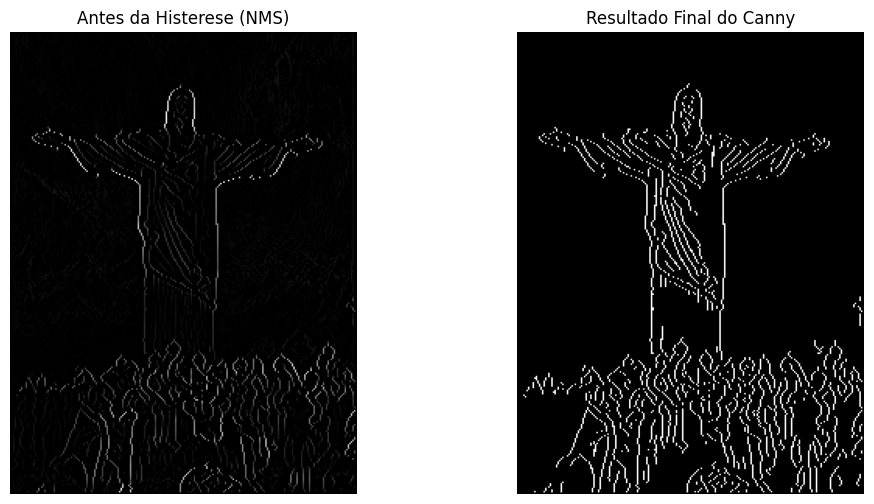

In [18]:
# Step 4 - Edge following

def histerese(image, limite_baixo, limite_alto):

  linhas, colunas = image.shape
  bordas_finais = np.zeros((linhas,colunas),dtype=np.uint8)

  #pixels fortes (>= limite_alto)
  fortes = (image >= limite_alto)

  #Pixels fracos (entre limite_baixo e limite_alto)
  fracos = (image >= limite_baixo) & (image < limite_alto)

  # Marca pixels fortes como borda
  bordas_finais[fortes] = 255

  # vizinhança de 8 pixels
  vizinhos = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

  # função para seguir as bordas
  def contornar_bordas(i,j):
    pixels = [(i,j)]
    while pixels:
      x, y = pixels.pop()
      for dx, dy in vizinhos:
        nx, ny = x + dx, y + dy
        if 0 <= nx < linhas and 0 <= ny < colunas:
          if fracos[nx, ny] and bordas_finais[nx, ny] == 0:
            bordas_finais[nx, ny] = 255
            pixels.append((nx, ny))

  # traço para cada pixel forte
  for i,j in zip(*np.where(fortes)):
    contornar_bordas(i,j)

  return bordas_finais

  #aplicando histerese

max_val = np.max(nms_image)
limite_alto = max_val * 0.10
limite_baixo = limite_alto * 0.5

final_canny_edges = histerese(nms_image, limite_baixo, limite_alto)

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(nms_image_8u, cmap='gray'), plt.title('Antes da Histerese (NMS)')
plt.axis('off')
plt.subplot(122), plt.imshow(final_canny_edges, cmap='gray'), plt.title('Resultado Final do Canny')
plt.axis('off')
plt.show()







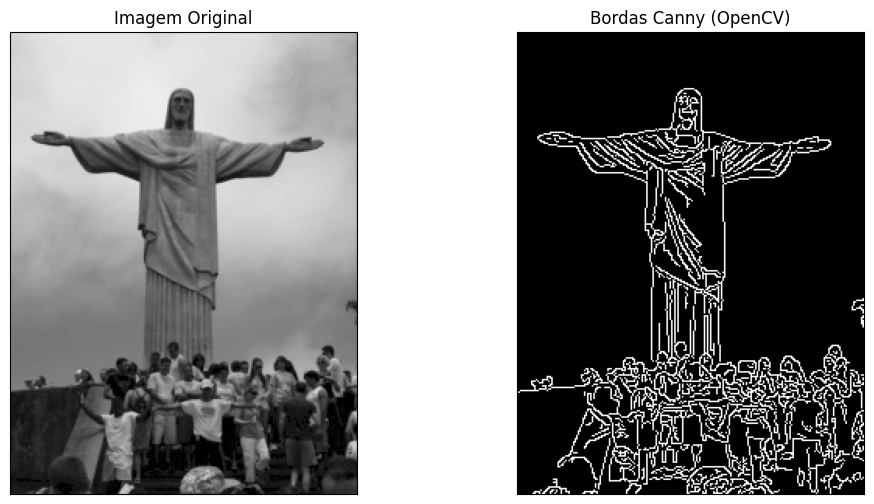

In [23]:
# Canny usando a função nativa do
# baseado em https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html


img = cv.imread(path_image, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

#definindo os limites
limite_alto_cv = 150
limite_baixo_cv = 50

# aplicando a função
bordas = cv.Canny(img,limite_baixo_cv, limite_alto_cv)

# Exibindo o resultado
plt.figure(figsize=(12, 6))

#imagem normal
plt.subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Imagem Original')
plt.xticks([]), plt.yticks([])

#imagem usando open_cv
plt.subplot(122)
plt.imshow(bordas, cmap='gray')
plt.title('Bordas Canny (OpenCV)')
plt.xticks([]), plt.yticks([])

plt.show()


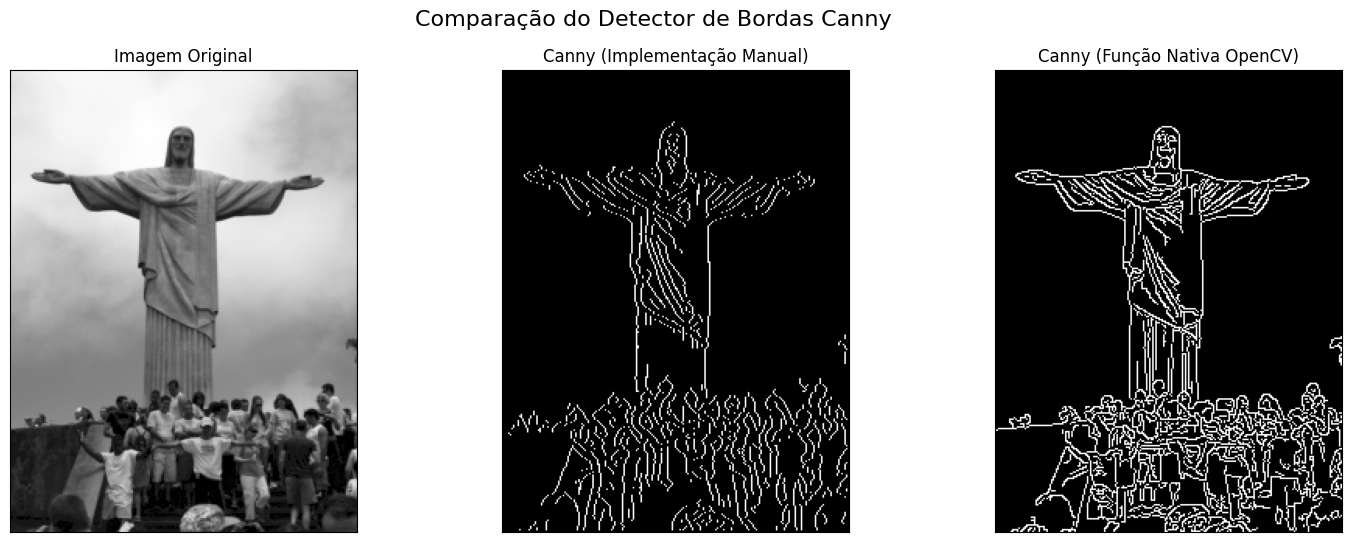

In [26]:
# comparação entre as imagens geradas

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(final_canny_edges, cmap='gray')
plt.title('Canny (Implementação Manual)')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(bordas, cmap='gray')
plt.title('Canny (Função Nativa OpenCV)')
plt.xticks([]), plt.yticks([])

plt.suptitle('Comparação do Detector de Bordas Canny', fontsize=16)
plt.show()